In [28]:
import h5py
import torch
import torch.nn as nn
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
import config
# import skfuzzy as fuzz

In [29]:
from torch.utils.data import DataLoader, TensorDataset

In [30]:
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
print(FILE_PATH)

/home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN/Torch_code


In [31]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [32]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 20


In [33]:
# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['550', '568']] # , ['5100','5109']
snr = 0 # dB

In [34]:
# file path
outer_file_path = os.path.join(FILE_PATH, '..', 'DeepMIMOv2', 'Gan_Data', 'Static_612x14', 'freq_symb_1ant_612sub')

H_true = np.empty((0, 2, 612, 14)) # true channel

H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
H_practical = np.empty((0, 2, 612, 14)) # noisy channel # Practical Estimated channel

# read data from ifferent .mat file, then concatenate them
for i in range(len(rows)):
    file_path_partial = 'Gan_0_dBOutdoor1_60_1ant_612subcs_Row_' + rows[i][0] +'_' + rows[i][1] + '.mat'

    file_path = os.path.join(outer_file_path, file_path_partial)
    file_path = os.path.normpath(file_path)
    file = h5py.File(file_path, 'r')
    
    H_true = np.concatenate((H_true, np.array(file['H_data'])), axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, np.array(file['H_equalized_data'])), axis = 0)
    H_linear = np.concatenate((H_linear, np.array(file['H_linear_data'])), axis=0)
    H_practical = np.concatenate((H_practical, np.array(file['H_practical_data'])), axis=0)

H_true.shape

(3439, 2, 612, 14)

In [35]:
shuffle_order = np.random.permutation(H_true.shape[0]);
H_true = torch.tensor(H_true[shuffle_order])
H_equal = torch.tensor(H_equal[shuffle_order])
H_linear = torch.tensor(H_linear[shuffle_order])
H_practical = torch.tensor(H_practical[shuffle_order])
H_true.shape
# Hreal = torch.tensor(Hreal)     
# input_data = torch.tensor(input_data)     

torch.Size([3439, 2, 612, 14])

In [36]:
train_size = np.floor(H_practical.shape[0]*0.9) //BATCH_SIZE *BATCH_SIZE
# print(train_size)
# print(train_size/64)
# print(train_size/input_data.size(0))
train_size = int(train_size)

# When input is H_linear (after LS+LI)

In [37]:
# [samples, 2, 612, 14]
# Split into training and validation sets for H_NN training
trainData   = H_linear[0:train_size,:,:,:].to(device, dtype=torch.float)
trainLabels = H_true[0:train_size,:,:,:].to(device, dtype=torch.float)

valData   = H_linear[train_size:,:,:,:].to(device, dtype=torch.float)
valLabels = H_true[train_size:,:,:,:].to(device, dtype=torch.float)

# Split H_equal, H_linear, H_practical for validation later
H_equal_val = H_equal[train_size:,:,:,:].to(device, dtype=torch.float)
H_linear_val = H_linear[train_size:,:,:,:].to(device, dtype=torch.float)
H_practical_val = H_practical[train_size:,:,:,:].to(device, dtype=torch.float)

In [38]:
# Normalization
trainData_min = trainData.min()
trainData_max = trainData.max()
trainLabels_min = trainLabels.min()
trainLabels_max = trainLabels.max()

trainData_normd   = (trainData - trainData_min)/ (trainData_max - trainData_min)
trainLabels_normd = (trainLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
valData_normd     = (valData - trainData_min)/ (trainData_max - trainData_min)
valLabels_normd   = (valLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
# for evaluation, output of model(valData) will be de-normalized and compared with valLabels

print(valData_normd.shape)
print(trainData_normd.shape)

torch.Size([367, 2, 612, 14])
torch.Size([3072, 2, 612, 14])


In [39]:
# Doppler_phase = exp(-1j*2*pi*params.carrier_freq*( ((path_params.Doppler_vel.*delay)./physconst('LightSpeed')) + ((path_params.Doppler_acc.*(delay.^2))./(2*physconst('LightSpeed'))) ));

In [40]:
plot = 0
if plot:
    H_temp = trainData_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = trainLabels_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

In [41]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((trainData_normd[:,0,:,:], trainData_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((trainLabels_normd[:,0,:,:], trainLabels_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)

trainData_normd.shape

torch.Size([6144, 1, 612, 14])

## Create a DataLoader for dataset

In [42]:
# Create a DataLoader for dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [4224, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData_normd, valLabels_normd)  # [241, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
# Validate roughly 5 times every epoch
valFrequency = round(trainData_normd.size(0)/BATCH_SIZE/5); 

In [44]:
class CNN_Est(nn.Module):
    def __init__(self):
        super(CNN_Est, self).__init__()
        
        self.normalization = nn.BatchNorm2d(1)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.relu  = nn.ReLU() 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        # Forward pass
        out = self.normalization(x)
        out = self.conv1(x)
        out = self.relu(out)  
        out = self.conv2(out)
        out = self.relu(out)  
        out = self.conv3(out)
        out = self.relu(out)  
        out = self.conv4(out)
        out = self.relu(out) 
        out = self.conv5(out)
        return out

In [45]:
model = CNN_Est().to(device)
print(model)

CNN_Est(
  (normalization): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [46]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

## Training Loop

In [47]:
# Training loop
train_loss =[]
val_loss = []
H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    if (epoch == num_epochs-1):
        i = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
    
    # Validation 
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = model(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_val_loss += val_loss_real.item()
            
            val_outputs_imag = model(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_val_loss += val_loss_imag.item()
            
            if (epoch == num_epochs-1):
                H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
            
    avg_val_loss = running_val_loss / (len(val_loader)*2)
    val_loss.append(avg_val_loss)    
            
    print(f" Val Loss: {avg_val_loss}")


Epoch 1/20, Loss: 0.09520867951990415 
 Val Loss: 0.026431360514834523
Epoch 2/20, Loss: 0.017790280175783362 
 Val Loss: 0.011876458923021952
Epoch 3/20, Loss: 0.008185818324515518 
 Val Loss: 0.003247061880150189
Epoch 4/20, Loss: 0.002055410073201832 
 Val Loss: 0.0014842586921683203
Epoch 5/20, Loss: 0.0012841835496146814 
 Val Loss: 0.0009839290481371183
Epoch 6/20, Loss: 0.0008701882764701926 
 Val Loss: 0.0007846410444471985
Epoch 7/20, Loss: 0.0006314082461358339 
 Val Loss: 0.0005165782131371088
Epoch 8/20, Loss: 0.0004843704098978681 
 Val Loss: 0.0004045273090014234
Epoch 9/20, Loss: 0.0003931634373657289 
 Val Loss: 0.0003365333723195363
Epoch 10/20, Loss: 0.00033535726000385085 
 Val Loss: 0.0003002873612179731
Epoch 11/20, Loss: 0.0003028161218026071 
 Val Loss: 0.000287826128139083
Epoch 12/20, Loss: 0.00027914076554225176 
 Val Loss: 0.00025247813876679476
Epoch 13/20, Loss: 0.0002601642430211844 
 Val Loss: 0.0002376561721272689
Epoch 14/20, Loss: 0.0002470307132777331

In [48]:
H_NN_val.shape

torch.Size([367, 2, 612, 14])

## After training

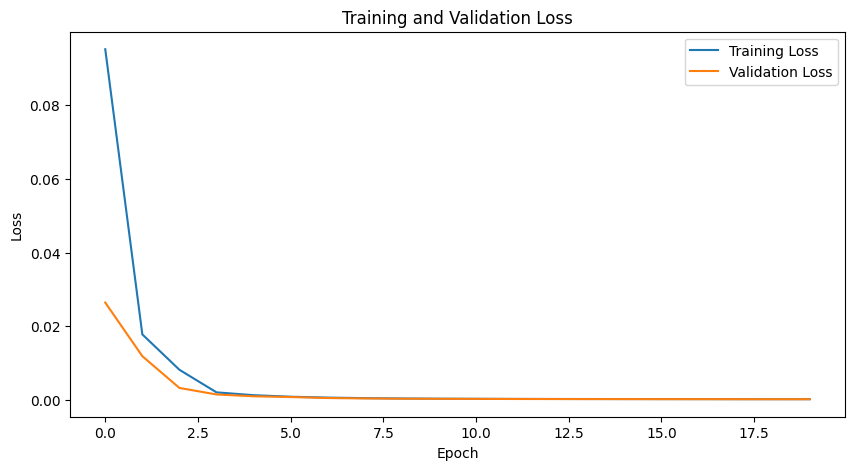

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

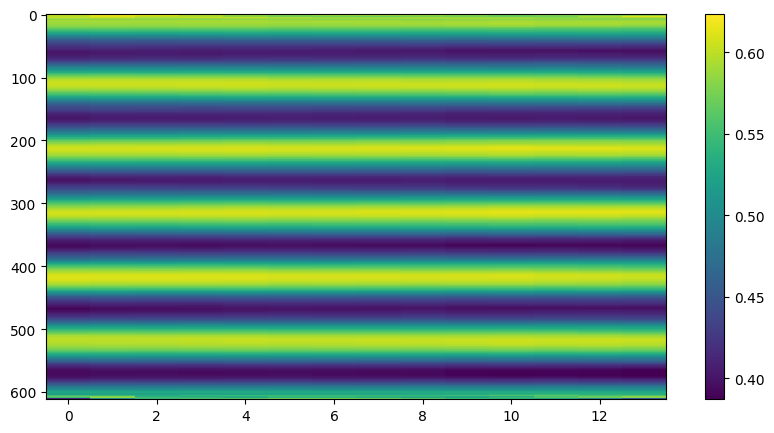

In [50]:
H_val_NN = H_NN_val.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

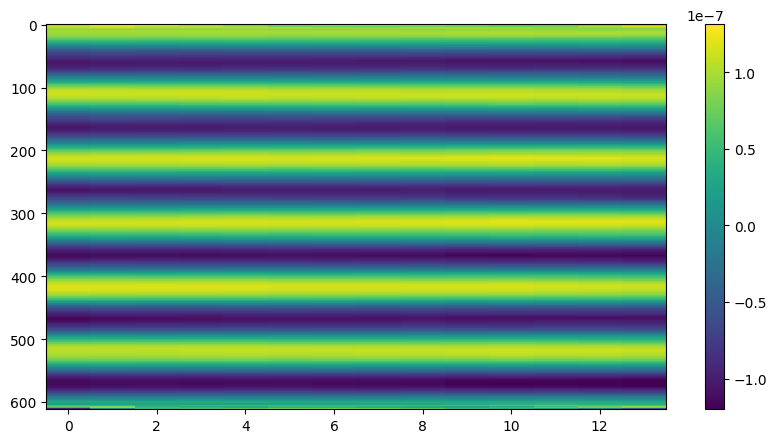

In [51]:
# De-normalized
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

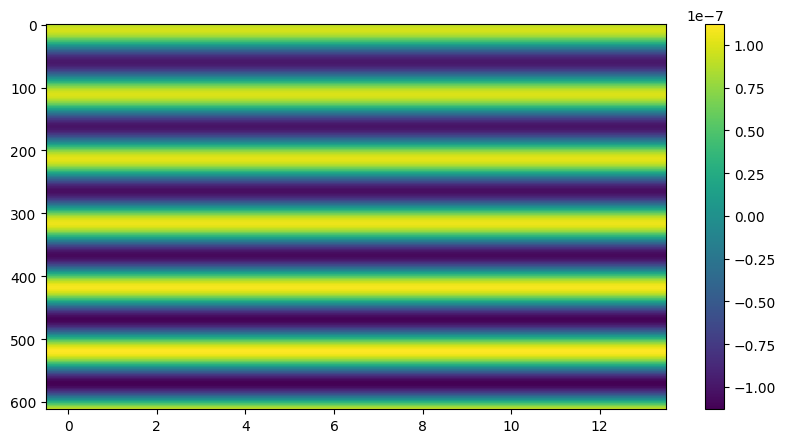

In [52]:
# True channel
H_val_true = valLabels.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

### Save LI+CNN Model

In [53]:
import loader
save_folder = os.path.join(config.FILE_PATH, 'model/static')

index_save = loader.find_incremental_filename(save_folder, 'CNN_', '_variable.mat')
model_save_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LI_CNN_model.pth')
variable_save_path = os.path.join(save_folder, 'CNN_' +str(index_save)+'_variable.mat')
variables = {   
            'SNR': snr,
            'epoc': NUM_EPOCHS,
            'rows': rows,
            'learning_rate': learning_rate,
            'H_val_true':H_val_true, # (nVal, 2, 612, 14)
            'H_val_LI_NN': H_val_NN, # (nVal, 2, 612, 14)
            'train_track_LI': train_loss,
            'val_track_LI': val_loss
}
# variable to save 
# Save the models' state dictionaries 
torch.save(model.state_dict(), model_save_path)


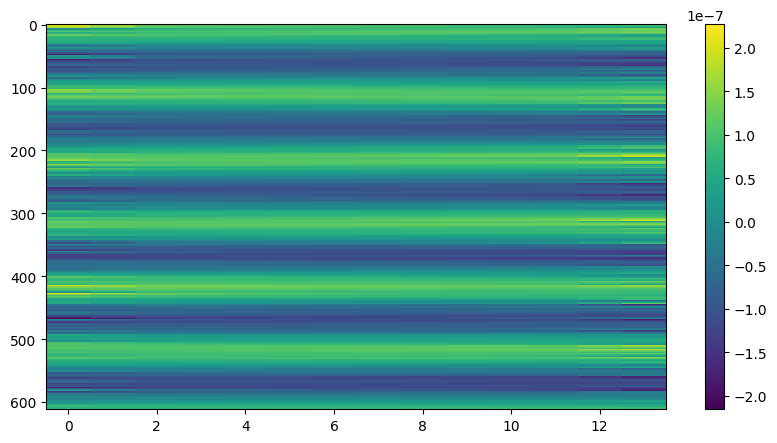

In [54]:
# Linear interpolated channel
H_val_linInterp = valData.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_linInterp[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [55]:
H_val_true.shape

torch.Size([367, 2, 612, 14])

In [56]:
# draw flow chart
# convert H to complex 
# check nmse formula in papers
# nmse vs SNR 
# try with GAN

### Calculate NMSE

In [57]:
# convert to complex matrices
H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:])
H_val_NN_denormd_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])
H_val_true_complex = torch.complex(H_val_true[:,0,:,:], H_val_true[:,1,:,:])

In [58]:
H_val_true_complex[1,1,1]

tensor(2.8718e-08+2.3864e-07j)

In [59]:
H_val_true_complex.shape

torch.Size([367, 612, 14])

In [60]:
# NMSE of Linear Interpolation
# Calculate the mean squared error
mse_LI = torch.mean(torch.abs(H_val_true_complex - H_val_linInterp_complex) ** 2)
# Calculate the variance of the reference tensor (complex_tensor1)
variance = torch.var(H_val_true_complex)
# Calculate the NMSE
nmse_LI = mse_LI / variance
print(f"NMSE: {nmse_LI.item()}")

NMSE: 0.08259456604719162


In [61]:
variables['NMSE_LI'] = nmse_LI

In [62]:
# NMSE of Linear Interpolation + NN
# Calculate the mean squared error
mse_LI_NN = torch.mean(torch.abs(H_val_true_complex - H_val_NN_denormd_complex) ** 2)
# Calculate the NMSE
nmse_LI_NN = mse_LI_NN / variance
print(f"NMSE: {nmse_LI_NN.item()}")

NMSE: 0.0077291675843298435


In [63]:
variables['NMSE_LI_NN'] = nmse_LI_NN

# When Input of the NN is just H_equalized

In [64]:
# [samples, 2, 612, 14]
# Split into training and validation sets for H_NN training
trainData   = H_equal[0:train_size,:,:,:].to(device, dtype=torch.float)
trainLabels = H_true[0:train_size,:,:,:].to(device, dtype=torch.float)

valData   = H_equal[train_size:,:,:,:].to(device, dtype=torch.float)
valLabels = H_true[train_size:,:,:,:].to(device, dtype=torch.float)

In [65]:
# Normalization
trainData_min = trainData.min()
trainData_max = trainData.max()
trainLabels_min = trainLabels.min()
trainLabels_max = trainLabels.max()

trainData_normd   = (trainData - trainData_min)/ (trainData_max - trainData_min)
trainLabels_normd = (trainLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
valData_normd     = (valData - trainData_min)/ (trainData_max - trainData_min)
valLabels_normd   = (valLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)


In [66]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((trainData_normd[:,0,:,:], trainData_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((trainLabels_normd[:,0,:,:], trainLabels_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)


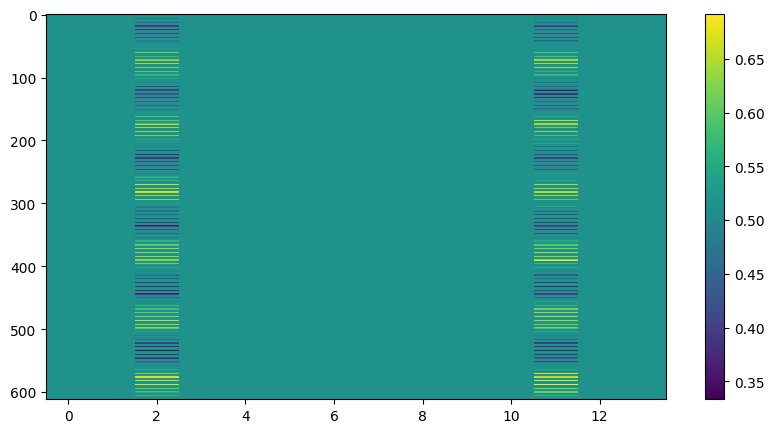

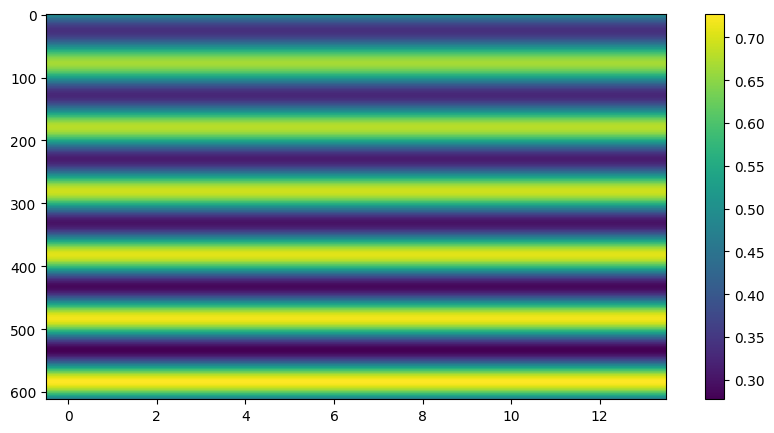

In [67]:
plot = 1
if plot:
    H_temp = trainData_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = trainLabels_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

## Create a DataLoader for dataset

In [68]:
# Create a DataLoader for dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [4224, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData_normd, valLabels_normd)  # [241, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [69]:
model2 = CNN_Est().to(device)
learning_rate = 0.00001
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

## Training Loop

In [70]:
# Training loop
train_loss =[]
val_loss = []
H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    if (epoch == num_epochs-1):
        i = 0
    for inputs, targets in train_loader:
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
    
    # Validation 
    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = model2(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_val_loss += val_loss_real.item()
            
            val_outputs_imag = model2(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_val_loss += val_loss_imag.item()
            
            if (epoch == num_epochs-1):
                H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
            
    avg_val_loss = running_val_loss / (len(val_loader)*2)
    val_loss.append(avg_val_loss)    
            
    print(f" Val Loss: {avg_val_loss}")

Epoch 1/20, Loss: 0.10217964264059749 
 Val Loss: 0.03066698128047089
Epoch 2/20, Loss: 0.025761415405819815 
 Val Loss: 0.021734568212802213
Epoch 3/20, Loss: 0.019784463748995524 
 Val Loss: 0.013928730273619294
Epoch 4/20, Loss: 0.006815500377949017 
 Val Loss: 0.0015000310668256134
Epoch 5/20, Loss: 0.0011257066456285731 
 Val Loss: 0.0008481588423213301
Epoch 6/20, Loss: 0.000812300363425796 
 Val Loss: 0.0006779913649855492
Epoch 7/20, Loss: 0.0006659826450838106 
 Val Loss: 0.0005689172733885547
Epoch 8/20, Loss: 0.0005706338783966203 
 Val Loss: 0.0005014167339444006
Epoch 9/20, Loss: 0.000508621704284451 
 Val Loss: 0.000459243750810856
Epoch 10/20, Loss: 0.0004693627408111449 
 Val Loss: 0.00042082790605491027
Epoch 11/20, Loss: 0.0004384324223186316 
 Val Loss: 0.0004008110360397647
Epoch 12/20, Loss: 0.0004214298911999019 
 Val Loss: 0.0003888385811781821
Epoch 13/20, Loss: 0.0004015497549213857 
 Val Loss: 0.0003686857489810791
Epoch 14/20, Loss: 0.00039196398468751187 
 V

## After training

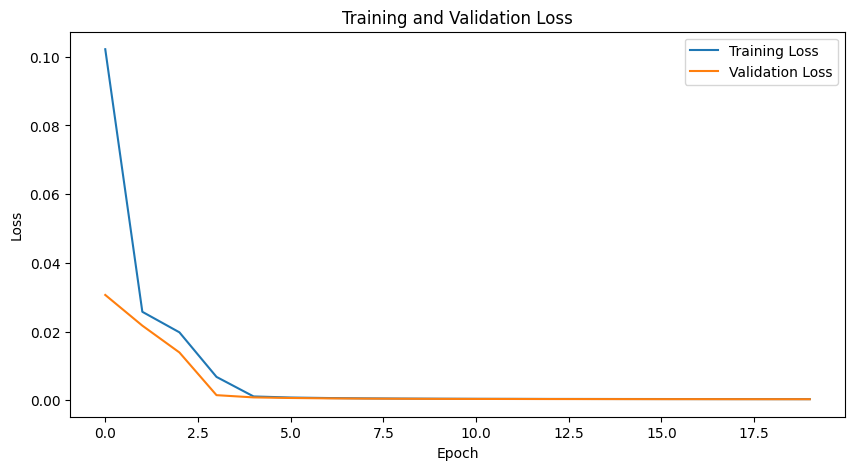

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [72]:
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()

### Save LS+NN Model and Variables

In [73]:
model_save_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LS_CNN_model.pth')

variables['H_val_LS_NN']= H_val_NN # (nVal, 2, 612, 14)
variables['train_track_LS']= train_loss
variables['val_track_LS']= val_loss
# variable to save 
# Save the models' state dictionaries 
torch.save(model.state_dict(), model_save_path)


In [74]:
H_val_LS_NN_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])


In [75]:
# NMSE of LS + NN
# Calculate the mean squared error
mse_LS_NN = torch.mean(torch.abs(H_val_true_complex - H_val_LS_NN_complex) ** 2)
# Calculate the NMSE
nmse_LS_NN = mse_LS_NN / variance
print(f"NMSE: {nmse_LS_NN.item()}")

NMSE: 0.012903948314487934


In [76]:
variables['NMSE_LS_NN'] = nmse_LS_NN

In [77]:
import scipy.io
scipy.io.savemat(variable_save_path, variables)